In [2]:
using CairoMakie, LinearAlgebra, Dierckx, Optim

In [102]:
pars = (;α = 0.33, # Capital share
         β = 0.9, # Discount factor
         γ = 2.0, # CRRA parameter
         δ = 0.1, # Depreciation rate
         A = 10.0, # TFP
         θ = 3.0, # Expanding grid parameter
         grid_size = 31, # number of gridpoints
         grid_min = 0.75, # minimum gridpoint (multiple of steady state capital stock)
         grid_max = 1.25, # maximum gridpoint (multiple of steady state capital stock)
         lb = 0.7, # lower bound for optimisation
         ub = 1.3, # upper bound for optimisation
         maxiter = 10000, # maximum number of iterations
         toler = 4e-7) # tolerance

(α = 0.33, β = 0.9, γ = 2.0, δ = 0.1, A = 10.0, θ = 3.0, grid_size = 31, grid_min = 0.75, grid_max = 1.25, lb = 0.7, ub = 1.3, maxiter = 10000, toler = 4.0e-7)

In [67]:
function utility(c, pars)
    if pars.γ == 1
        return log(c)
    else
        return (c^(1-pars.γ))/(1-pars.γ)
    end
end

function production(k, kp, pars)
    (;A, α, δ) = pars
    return A*k^α + (1.0-δ)*k - kp
end

function exp_grid(pars)
    (; θ, grid_min, grid_max, grid_size, A, α, β, δ) = pars
    Kss = ((A*α*β)/(1-β*(1.0-δ)))^(1/(1.0-α)) 
    grid = LinRange(0.0, 1.0, grid_size)
    grid = grid_min*Kss .+ (grid_max*Kss .- grid_min*Kss).*grid.^θ
    return grid
end

function interpV(grid, v)
    return Spline1D(grid, v, k=3, bc="extrapolate")
end

function optimise(grid, interp_v, policy, pars)
    (; grid_size, lb, ub, β, A, α, δ) = pars
    v_new = zeros(grid_size)
    Kss = ((A*α*β)/(1-β*(1.0-δ)))^(1/(1.0-α))
    for i in 1:grid_size
        obj(kp) = - (utility(production(grid[i], kp, pars), pars) + β * interp_v(kp))
        res = optimize(obj,Kss*lb,Kss*ub)
        policy[i] = res.minimizer
        v_new[i] = -res.minimum
    end
    return v_new, policy
end

optimise (generic function with 1 method)

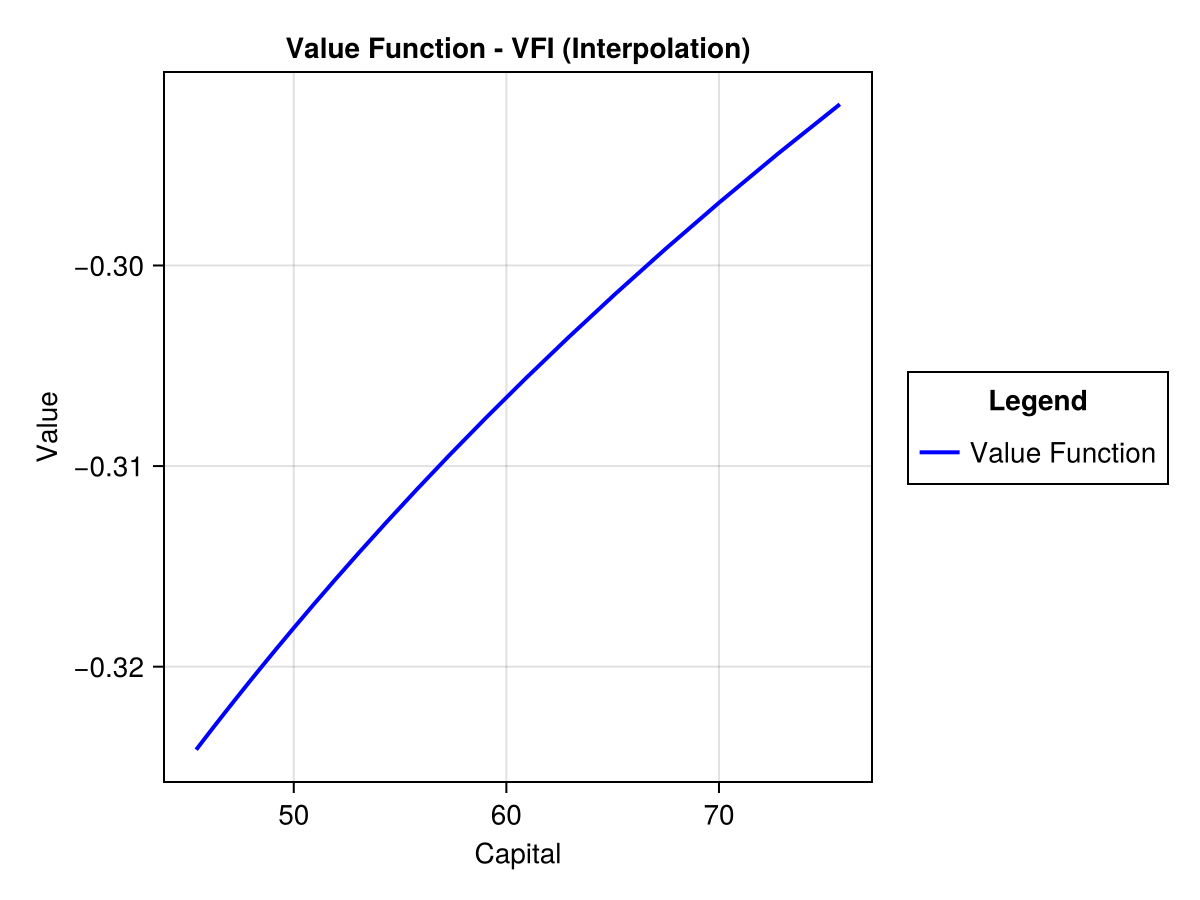

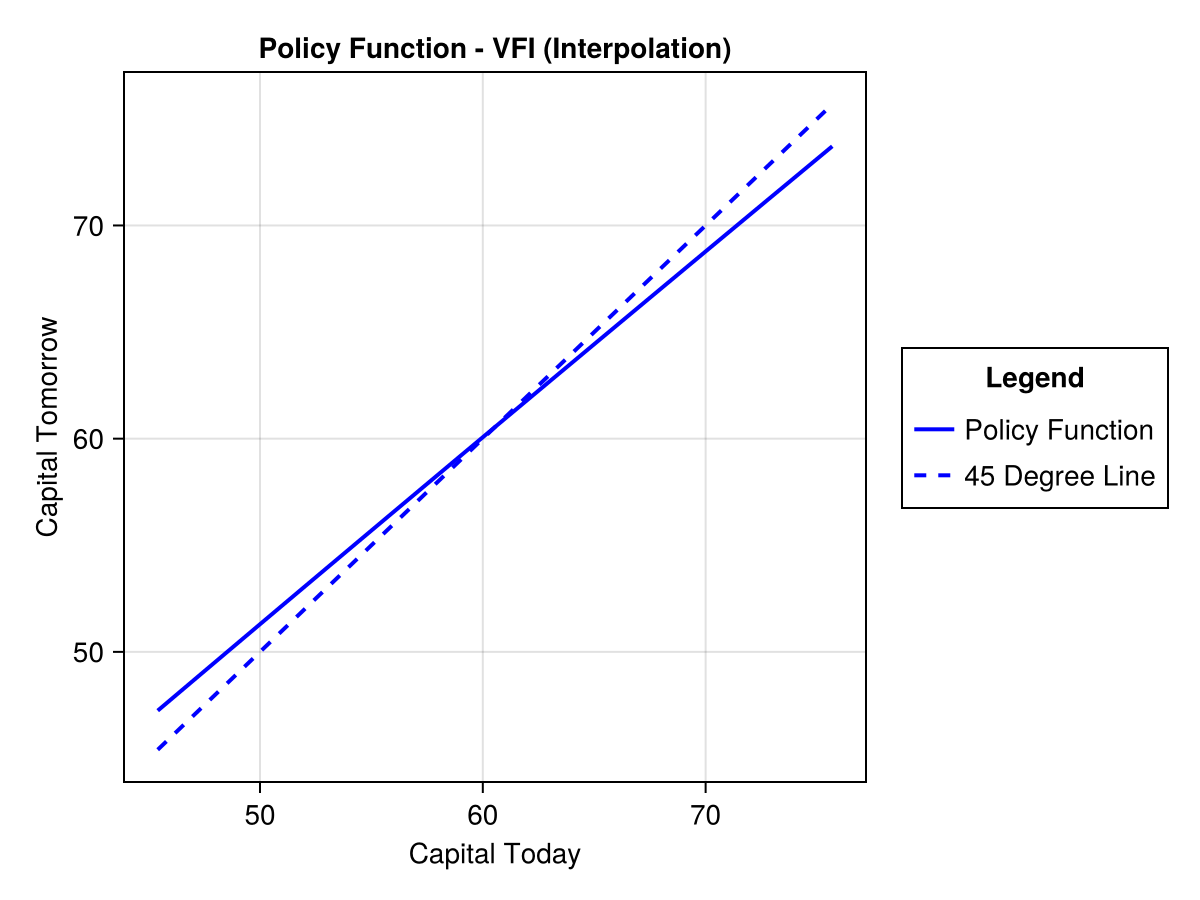

(Float32[-0.3241405, -0.32413894, -0.32412803, -0.32409847, -0.32404092, -0.32394615, -0.32380506, -0.32360867, -0.32334828, -0.32301548  …  -0.31115684, -0.30942422, -0.30758014, -0.3056286, -0.30357432, -0.3014227, -0.29917943, -0.29685083, -0.29444328, -0.29196346], Float32[47.243164, 47.244156, 47.251106, 47.269966, 47.306694, 47.36724, 47.457558, 47.583584, 47.75125, 47.96649  …  56.38797, 57.75044, 59.24078, 60.864502, 62.62709, 64.53404, 66.59084, 68.80284, 71.175766, 73.714226])

In [103]:
function vfi(v, pars)
    (; α, β, δ, grid_size, maxiter, toler, A) = pars
    v_init = ones(grid_size)
    policy = similar(v)
    K = exp_grid(pars)
    error = toler + 1
    iter = 0
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < maxiter))
        v = interpV(K, v_init)
        v_new, policy = optimise(K, v, policy, pars)
        error = maximum(abs.(v_new - v_init)/1.0+abs.(v_new))
        v_init .= v_new
        if iter % 10 == 0
            println("---------------------")
            println("Completed iteration $iter with error $error\n")
        end
        iter += 1
    end
    println("--------------------")
    println("Converged after $iter iterations with error $error\n")
    println("--------------------")

    K = vec(Float32.(K))
    v_init = vec(Float32.(v_init))
    fig1 = Figure()
    ax1 = Axis(fig1[1, 1], title = "Value Function - VFI (Interpolation)", xlabel = "Capital", ylabel = "Value")
    lines!(ax1, K, v_init, color = :blue, linewidth = 2, label = "Value Function")
    legend = Legend(fig1[1, 2], ax1, "Legend", orientation = :vertical)
    display(fig1)

    policy = vec(Float32.(policy))
    fig2 = Figure()
    ax2 = Axis(fig2[1, 1], title = "Policy Function - VFI (Interpolation)", xlabel = "Capital Today", ylabel = "Capital Tomorrow")
    lines!(ax2, K, policy, color = :blue, linewidth = 2, label = "Policy Function")
    lines!(ax2, K, K, color = :blue, linestyle = :dash, linewidth = 2, label = "45 Degree Line")
    legend = Legend(fig2[1, 2], ax2, "Legend", orientation = :vertical)
    display(fig2)

    return v_init, policy
end

test_v = zeros(pars.grid_size)
v_out, policy_out = vfi(test_v, pars)

In [73]:
function utility_EV(c, pars)
    return (c^(1-pars.γ))
end

function production(k, kp, pars)
    (;A, α, δ) = pars
    return A*k^α + (1.0-δ)*k - kp
end

function exp_grid(pars)
    (; θ, grid_min, grid_max, grid_size, A, α, β, δ) = pars
    Kss = ((A*α*β)/(1-β*(1.0-δ)))^(1/(1.0-α)) 
    grid = LinRange(0.0, 1.0, grid_size)
    grid = grid_min*Kss .+ (grid_max*Kss .- grid_min*Kss).*grid.^θ
    return grid
end

function interpV_EV(grid, v)
    interp = Spline1D(grid, v, k=3, bc="extrapolate")
    transformed_interp(x) = interp(x)^(1.0-pars.γ)
    @show typeof(transformed_interp)
    return transformed_interp
end

function optimise_EV(grid, interp_v, policy, pars)
    (; grid_size, lb, ub, β, A, α, δ, γ) = pars
    v_new = zeros(grid_size)
    Kss = ((A*α*β)/(1-β*(1.0-δ)))^(1/(1.0-α))
    for i in 1:grid_size
        obj_EV(kp) = - ( (1-β) * utility_EV(production(grid[i], kp, pars), pars) + β * interp_v(kp))^(1.0/(1.0-γ))
        res = optimize(obj_EV,Kss*lb,Kss*ub)
        policy[i] = res.minimizer
        v_new[i] = -res.minimum
    end
    return v_new, policy
end

(::var"#transformed_interp#48"{Spline1D}) (generic function with 1 method)

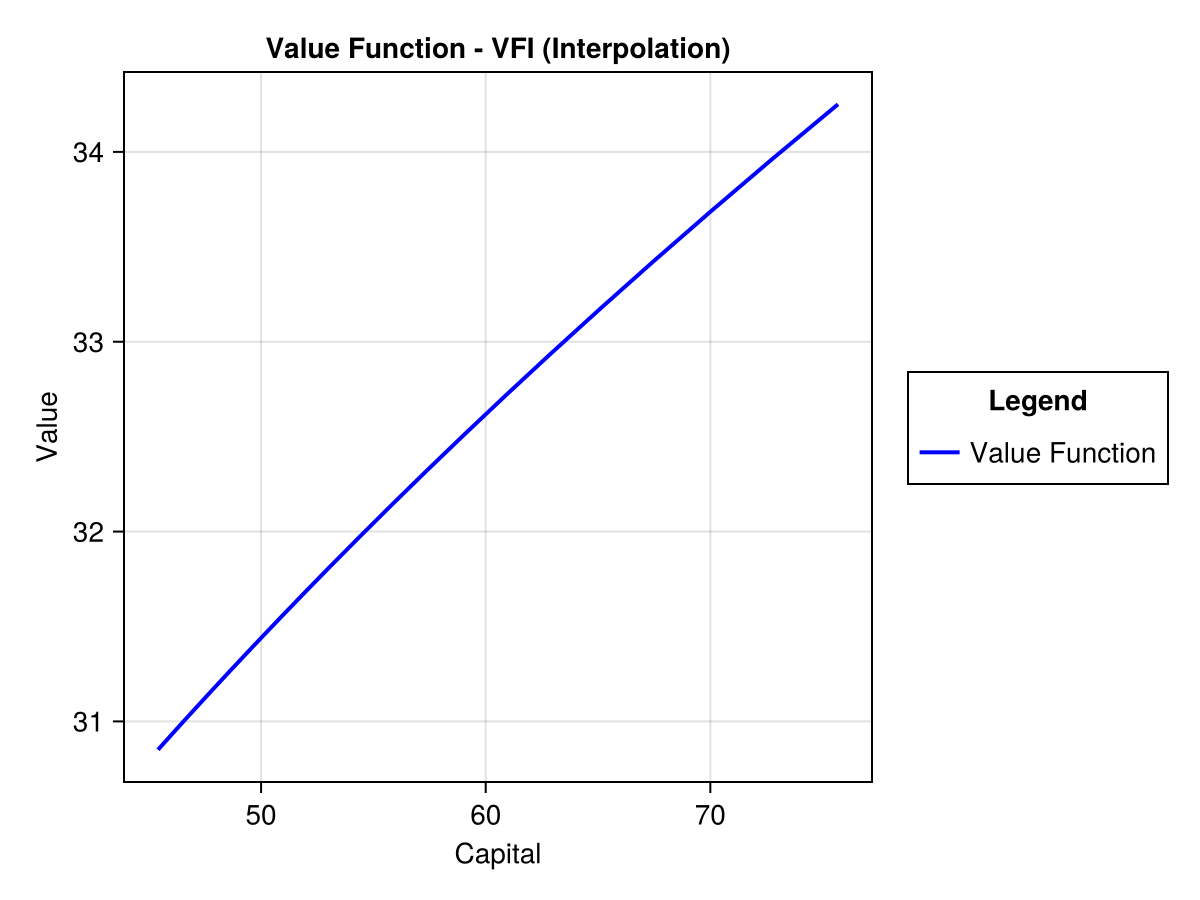

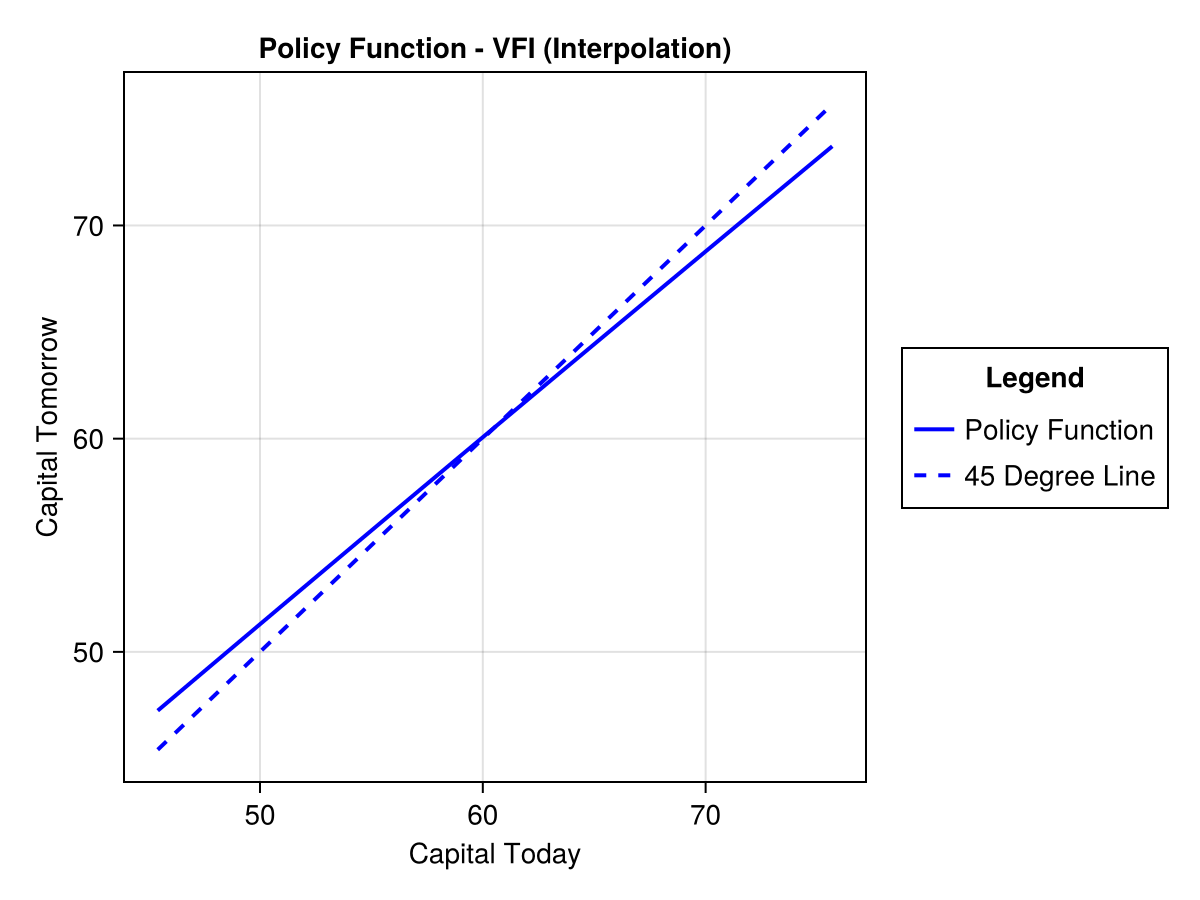

(Float32[30.85082, 30.85097, 30.852007, 30.854822, 30.8603, 30.869328, 30.882778, 30.901522, 30.926407, 30.958267  …  32.138134, 32.31809, 32.511852, 32.71945, 32.94086, 33.176003, 33.424755, 33.686954, 33.9624, 34.250862], Float32[47.243164, 47.24416, 47.251106, 47.26997, 47.306694, 47.36724, 47.457558, 47.58358, 47.75125, 47.96649  …  56.38797, 57.75044, 59.240776, 60.8645, 62.627098, 64.53406, 66.590836, 68.80286, 71.17568, 73.7144])

In [104]:
function vfi_EV(v, pars)
    (; α, β, δ, grid_size, maxiter, toler, A) = pars
    v_init = ones(grid_size)
    v_new = similar(v)
    policy = similar(v)
    K = exp_grid(pars)
    error = toler + 1
    iter = 0
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < maxiter))
        v = interpV_EV(K, v_init)
        v_new, policy = optimise_EV(K, v, policy, pars)
        error = maximum(abs.(v_new - v_init)/1.0+abs.(v_new))
        v_init .= v_new
        if iter % 100 == 0
            println("---------------------")
            println("Completed iteration $iter with error $error\n")
        end
        iter += 1
    end
    println("--------------------")
    println("Converged after $iter iterations with error $error\n")
    println("--------------------")

    K = vec(Float32.(K))
    v_init = vec(Float32.(v_init))
    fig1 = Figure()
    ax1 = Axis(fig1[1, 1], title = "Value Function - VFI (Interpolation)", xlabel = "Capital", ylabel = "Value")
    lines!(ax1, K, v_init, color = :blue, linewidth = 2, label = "Value Function")
    legend = Legend(fig1[1, 2], ax1, "Legend", orientation = :vertical)
    display(fig1)

    policy = vec(Float32.(policy))
    fig2 = Figure()
    ax2 = Axis(fig2[1, 1], title = "Policy Function - VFI (Interpolation)", xlabel = "Capital Today", ylabel = "Capital Tomorrow")
    lines!(ax2, K, policy, color = :blue, linewidth = 2, label = "Policy Function")
    lines!(ax2, K, K, color = :blue, linestyle = :dash, linewidth = 2, label = "45 Degree Line")
    legend = Legend(fig2[1, 2], ax2, "Legend", orientation = :vertical)
    display(fig2)

    return v_init, policy
end

test_v = zeros(pars.grid_size)
v_EV, pol_EV = vfi_EV(test_v, pars)